# Author

Student name: Shai Lynch

Student Number: 180540604

# Problem Formulation

-  From this dataset the problem which will be solved will be the use of a machine learning model that has the capabilities to classify whether an audio segment is indoor or outdoor
- The application of audio segmentation is:

    1) The model can be used to understand whether an individual is outside or inside, based on the noise in the background.
    2) Secondly, audio classification can be used to identify if an individual is indoor and this could prompt use of smart light.
    3) Audio classification can be used in accident detection where if an accident were to occur based on the noise and sound the model could detect whether the accident occurred indoor or outdoor.

# Library Importation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import Image
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Dataset 

* For this application, the dataset would consist of 2500 audio files which are from 6 areas which might be indoor or outdoor. The audio starts with "This is London", this indicates a start of the audio. The audio sounds will vary based on the time taken whether it is peak hours, hence why two locations could have two different audio quality. Other locations have loud areas and quiet areas as well.

In [2]:
data_path = '/Users/shailynch/Downloads/machineLearning/MLEndLS_Sample/*.wav'

files = glob.glob(data_path)
print("The amount of files present are: ",len(files))

The amount of files present are:  2498


In [3]:
#Create a dataframe containing the information about the wav files 
ML_df = pd.read_csv('./MLEndLS.csv').set_index('file_id')

#The shape of the dataframe
print("The shape of the dataframe is: ",ML_df.shape)
ML_df

The shape of the dataframe is:  (2498, 4)


,area,spot,in_out,Participant
file_id,,,,
0001.wav,british,street,outdoor,S151
0002.wav,kensington,dinosaur,indoor,S127
0003.wav,campus,square,outdoor,S18
0004.wav,kensington,hintze,indoor,S179
0005.wav,campus,square,outdoor,S176
...,...,...,...,...
2496.wav,westend,trafalgar,outdoor,S151
2497.wav,campus,square,outdoor,S6
2498.wav,westend,national,indoor,S96


# Machine Learning Pipeline

A machine learning pipeline is the process from start to finish. 

    1. An audio segment is loaded
    2. Features are extracted
    3. The model is trained 
    4. Accuracy is tested
    5. Label is returned

# Transformation Stage

To be able to train a model the audio contains features that are able to distinguish the various features. The transformation stage will include extract the following features.
    
    Pitch Mean: Pitch is a measure of the perceived highness or lowness of a sound. The pitch mean is the average pitch of a sound over a given period of time.

    Pitch Standard Deviation: The pitch standard deviation is a measure of the variation in pitch over a given period of time. A small standard deviation indicates that the pitch is relatively stable, while a large standard deviation indicates that the pitch is more variable.

    Fraction of Voiced Region: The fraction of voiced region is a measure of the proportion of time in a sound sample that is characterized by voiced speech. In voiced speech, the vocal cords vibrate to produce sound, while in unvoiced speech, air is simply pushed out of the mouth without vocal cord vibration.

    Mel Frequency Cepstrum: The mel frequency cepstrum is a representation of the spectral characteristics of a sound that is based on a logarithmic scale of frequencies. It is commonly used in speech recognition and other applications involving the analysis of speech and audio signals.

    Spectral Centroid: The spectral centroid is a measure of the "brightness" of a sound. It is calculated by taking the weighted average of the frequencies present in a sound, with the weights being determined by the amplitudes of the frequencies. A sound with a high spectral centroid is perceived as "bright", while a sound with a low spectral centroid is perceived as "dark"


# Feature Extraction 


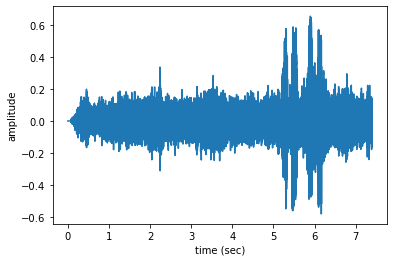

In [4]:
n=0
fs = None # Sampling frequency
x, fs = librosa.load(files[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))

In [5]:
#Samples in the audio segment
n=0
x, fs = librosa.load(files[n],sr=fs)
print('This audio signal has', len(x), 'samples')

This audio signal has 326340 samples


In [6]:
#The code below shows the location of the audio file above
ML_df.loc[files[n].split('/')[-1]]

area             westend
spot           trafalgar
in_out           outdoor
Participant         S130
Name: 2217.wav, dtype: object

In [7]:
#Retrieve the pitch of the audio
def getPitch(x,fs,winLen=0.02):
    p = winLen *fs
    frame_length = int(2**int(p-1).bit_length())
    hop_length = frame_length//2
    f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                frame_length=frame_length,hop_length=hop_length)
    return f0,voiced_flag

In [8]:
##Create a function to identify whether recording is indoor or outdoor, by using 4 primary audio features, 5 extra audio features and label y 0=outdoor and 1 = indoor
def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False):
    X,y =[],[]
    for file in tqdm(files):
        fileID = file.split('/')[-1]
        file_name = file.split('/')[-1]
        yi = labels_file.loc[fileID]['in_out']=='indoor'

        fs = None # if None, fs would be 22050
        try:
            x, fs = librosa.load(file,sr=fs)
            if scale_audio: x = x/np.max(np.abs(x))
            f0, voiced_flag = getPitch(x,fs,winLen=0.02)#
            #the 4  primary features in x
            power = np.sum(x**2)/len(x)
            pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
            pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
            voiced_fr = np.mean(voiced_flag)

            #The extra features from the audio file
            #Mel Frequeny Spectogram
            mfcc = np.mean(librosa.feature.mfcc(x,sr=fs,n_mfcc=13))
            #Spectral Centroid
            sc = np.mean(librosa.feature.spectral_centroid(x,sr=fs))

            #Create an array to store the various features
            xi = [power,pitch_mean,pitch_std,voiced_fr,mfcc,sc]

            #Append the results to the X and y variables
            X.append(xi)
            y.append(yi)
        except Exception as i:
            continue

    return np.array(X),np.array(y)

/opt/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  return f(*args, **kwargs)


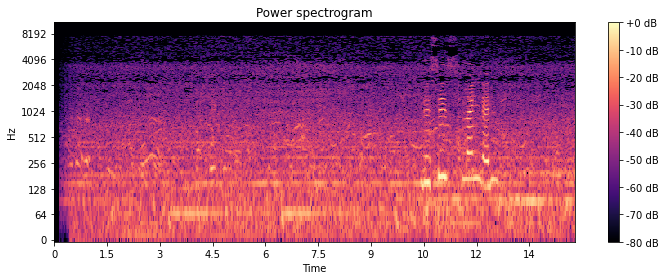

In [9]:
#Spectogram Visualisation 
n=0
x, fs = librosa.load(files[n],sr=fs)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(x), ref=np.max), y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Power spectrogram')
plt.tight_layout()
plt.show()

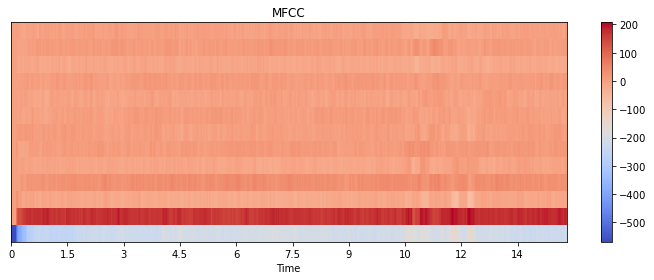

In [10]:
#MFCC Visualisation
n=0
x, fs = librosa.load(files[n],sr=fs)
mfcc = librosa.feature.mfcc(x,sr=fs,n_mfcc=13)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()


In [11]:
#Apply the function to identify indoor and outdoor recordings 
X,y = getXy(files, labels_file=ML_df, scale_audio=True, onlySingleDigit=True)

100%|██████████| 2498/2498 [45:52<00:00,  1.10s/it]    


Below is the output of the two files which had no pitch, making them unuseable for this problem

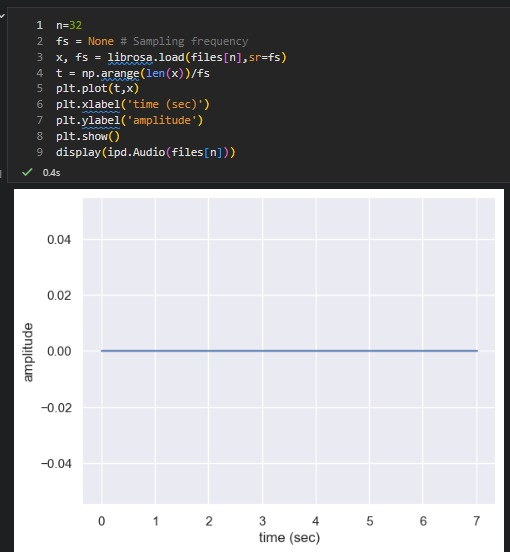

In [12]:
Image("/Users/shailynch/Downloads/machineLearning/33file.jpeg")

Image("Broken file (2206).png")

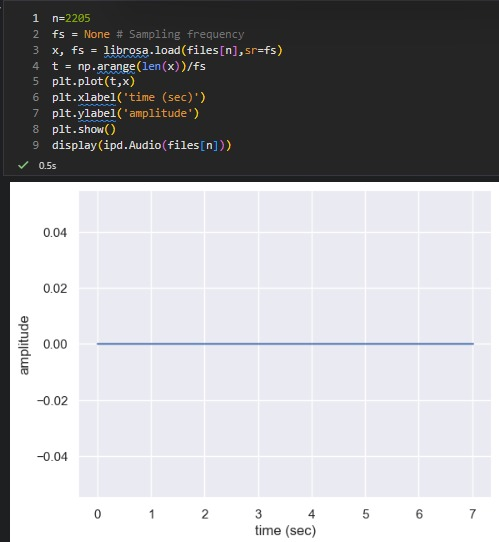

In [13]:
Image('/Users/shailynch/Downloads/machineLearning/2206file.jpeg')

In [14]:
#How many of our samples are indoor and outdoor
print(' The number of indoor recordings is ', np.count_nonzero(y))
print(' The number of outdoor recordings is ', y.size - np.count_nonzero(y))

 The number of indoor recordings is  1181
 The number of outdoor recordings is  1317


# Methodology

To train the model the use of various methods to ensure that the model is well trained. Firstly the data will be: 
    
    a. K-fold cross validation — a resampling technique in which models are assessed on a small subset of data.
        i)K-fold cross validation is helpful since it helps lessen the effects of bias and overfitting.

        ii) The variance of the outcomes decreases as K grows.
        iii)One of K-fold cross validation's drawbacks is that it requires a lot of processing power.
    b. GridSearchCV - This technique allows determining the best parameter values from a given collection of parameters.
    
    i)To begin with, it uses the computer's resources wisely.
    ii)Allows a model to be specified for every possible combination of these hyperparameters and then assesses the performance of those models
    iii)Grid search has the drawback of being computationally costly.

# Evaluation 
A number of methods can be employed during evaluation to ascertain the model's efficacy.

    a. A classification algorithm's Confusion Matrix summarises the model's accuracy in two dimensions: prediction and observation
    b. Accuracy - Gives the strength of the positive predictions.
    c. Recall: Returns the percentage of true positive observations relative to the total number of observations in the class.
    d. The F1 Score is a performance measure for binary classification that takes into account both recall and accuracy and averages them out.
    e. Receiver Operating Characteristic Curve (ROC) – Evaluates classifier efficiency when threshold is held constant.



# Machine Learning Modelling 

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
import seaborn as sns

#Create a train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

SVC

In [16]:
#import SVC
from sklearn.svm import SVC

#Pipeline 
svc_pipe = Pipeline([('scaler', StandardScaler()),(('svc',SVC()))])


#param for SVC
param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': [0.001, 0.01, 0.1, 1],
    'svc__kernel': ['rbf', 'linear']
}

#KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#GridSearchCV
svc_grid = GridSearchCV(svc_pipe, param_grid, cv=kf, verbose=1, n_jobs=-1)

#Fit
svc_grid.fit(X_train,y_train)

#Best parameters
best_param = svc_grid.best_params_

#Best score
bets_svc = svc_grid.best_score_

best_param

Fitting 5 folds for each of 32 candidates, totalling 160 fits


{'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}

In [17]:
bets_svc

0.683068358575522

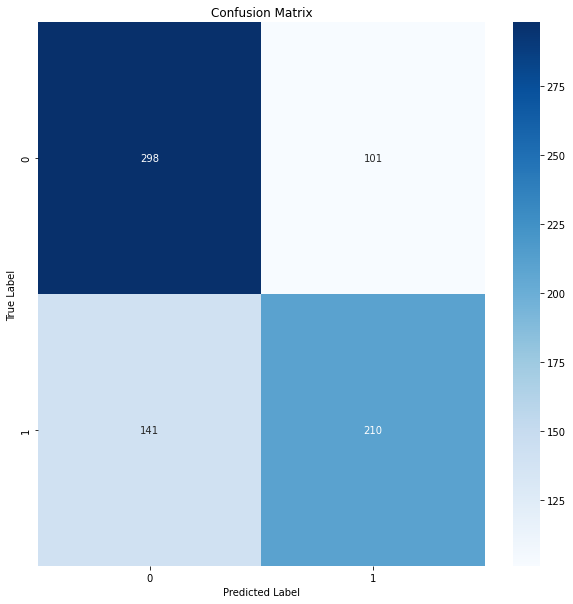

              precision    recall  f1-score   support

       False       0.68      0.75      0.71       399
        True       0.68      0.60      0.63       351

    accuracy                           0.68       750
   macro avg       0.68      0.67      0.67       750
weighted avg       0.68      0.68      0.68       750



In [18]:
#Confusion Matrix
y_pred = svc_grid.predict(X_test)

#Confusion Matrix
cm = confusion_matrix(y_test,y_pred)

#Plot Confusion Matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#Classification Report
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

       False       0.68      0.75      0.71       399
        True       0.68      0.60      0.63       351

    accuracy                           0.68       750
   macro avg       0.68      0.67      0.67       750
weighted avg       0.68      0.68      0.68       750



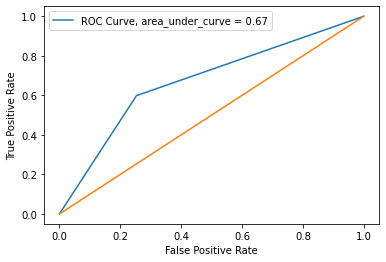

In [19]:
#Find the roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
#Find the area under curve
area_under_curve = round(roc_auc_score(y_test, y_pred),2)
#plot the roc_curve
plt.plot(fpr, tpr, label='ROC Curve, area_under_curve = %0.2f'%area_under_curve)
#plot the roc_auc_score
plt.plot([0, 1], [0, 1])
plt.ylabel('True Positive Rate')
plt.legend()
#plot the 
plt.xlabel('False Positive Rate')
print(classification_report(y_test, y_pred))

In [20]:
#pipe with best param 
svc_pipe = Pipeline([('scaler', StandardScaler()),('svc',SVC(C=10,gamma=0.01,kernel='rbf'))])

Random Forest Classifier

In [21]:
from sklearn.ensemble import RandomForestClassifier

#Pipeline
rf_pipe = Pipeline([('scaler', StandardScaler()),('rf',RandomForestClassifier())])

#Param for RF
param_grid = {
    'rf__n_estimators': [10, 50, 100, 200],
    'rf__max_depth': [5, 10, 15, 20],
    'rf__max_features': ['sqrt', 'log2', None]
}

#KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#GridSearchCV
rf_grid = GridSearchCV(rf_pipe, param_grid, cv=kf, verbose=1, n_jobs=-1)

#Fit
rf_grid.fit(X_train,y_train)

#Best score
rf_best = rf_grid.best_score_

#Best parameters
rf_grid.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'rf__max_depth': 10, 'rf__max_features': None, 'rf__n_estimators': 50}

              precision    recall  f1-score   support

       False       0.67      0.69      0.68       399
        True       0.64      0.61      0.62       351

    accuracy                           0.65       750
   macro avg       0.65      0.65      0.65       750
weighted avg       0.65      0.65      0.65       750



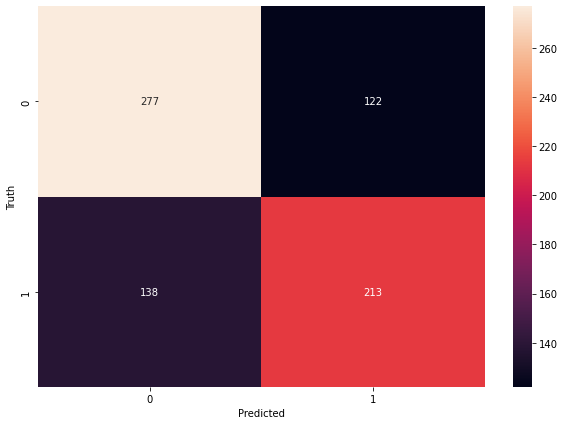

In [22]:
#Confusion Matrix
y_pred = rf_grid.predict(X_test) 
cm = confusion_matrix(y_test, y_pred)

#Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

#Classification Report
print(classification_report(y_test, y_pred))


In [23]:
#Pipeline
rf_pipe = Pipeline([('scaler', StandardScaler()),('rf',RandomForestClassifier(max_depth=20,max_features='sqrt',n_estimators=200))])


XGBoost

In [24]:
from xgboost import XGBClassifier

#Pipeline
xgb_pipe = Pipeline([('scaler', StandardScaler()),('xgb',XGBClassifier())])

#Param for XGB
param_grid = {
    'xgb__max_depth': [3, 5, 7, 9],
    'xgb__learning_rate': [0.1, 0.3, 0.5, 0.7],
    'xgb__n_estimators': [100, 200, 300, 400]
}

#KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#GridSearchCV
xgb_grid = GridSearchCV(xgb_pipe, param_grid, cv=kf, verbose=1, n_jobs=-1)

#Fit
xgb_grid.fit(X_train,y_train)

 
#Best score
xgb_best = xgb_grid.best_score_

#Best parameters
xgb_grid.best_params_

Fitting 5 folds for each of 64 candidates, totalling 320 fits


{'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 100}

              precision    recall  f1-score   support

       False       0.68      0.70      0.69       399
        True       0.65      0.63      0.64       351

    accuracy                           0.67       750
   macro avg       0.67      0.66      0.66       750
weighted avg       0.67      0.67      0.67       750



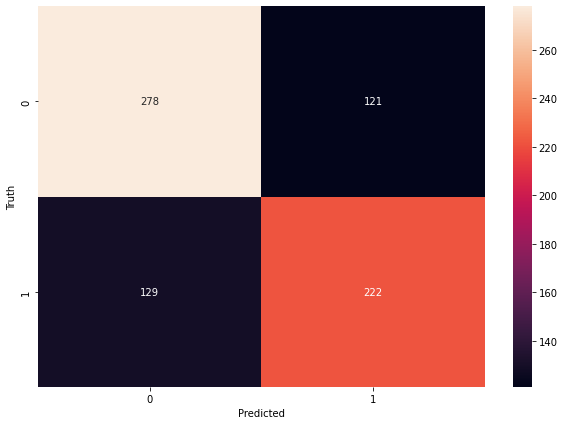

In [25]:
#Confusion Matrix
y_pred = xgb_grid.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

#Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

#Classification Report
print(classification_report(y_test, y_pred))

K Nearest Neighbour

In [26]:
from sklearn.neighbors import KNeighborsClassifier

#Pipeline
knn_pipe = Pipeline([('scaler', StandardScaler()),('knn',KNeighborsClassifier())])

#Param for KNN
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance']
}

#KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

 
#GridSearchCV
knn_grid = GridSearchCV(knn_pipe, param_grid, cv=kf, verbose=1, n_jobs=-1)

#Fit
knn_grid.fit(X_train,y_train)

#Best parameters
knn_grid.best_params_

#Best score
knn_best = knn_grid.best_score_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


              precision    recall  f1-score   support

       False       0.64      0.61      0.62       399
        True       0.58      0.61      0.59       351

    accuracy                           0.61       750
   macro avg       0.61      0.61      0.61       750
weighted avg       0.61      0.61      0.61       750



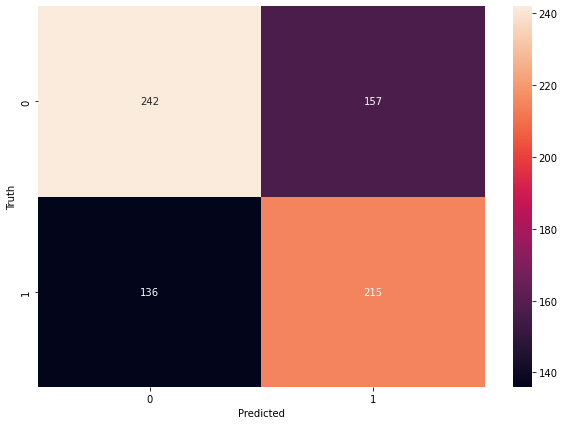

In [27]:
#Confusion Matrix
y_pred = knn_grid.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

#Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

#Classification Report
print(classification_report(y_test, y_pred))

Linear SVC

In [28]:
from sklearn.svm import LinearSVC

#Pipeline
lsvc_pipe = Pipeline([('scaler', StandardScaler()),('lsvc',LinearSVC())])

#Param for LSVC
param_grid = {
    'lsvc__C': [0.1, 1, 10, 100],
    'lsvc__dual': [True, False],
    'lsvc__penalty': ['l1', 'l2'],
    'lsvc__tol': [1e-4, 1e-3, 1e-2, 1e-1]
}

#KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#GridSearchCV
lsvc_grid = GridSearchCV(lsvc_pipe, param_grid, cv=kf, verbose=1, n_jobs=-1)

#Fit
lsvc_grid.fit(X,y)

#Best score
lsvc_best = lsvc_grid.best_score_

#Best parameters
lsvc_grid.best_params_

Fitting 5 folds for each of 64 candidates, totalling 320 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number 

{'lsvc__C': 10, 'lsvc__dual': True, 'lsvc__penalty': 'l2', 'lsvc__tol': 0.0001}

              precision    recall  f1-score   support

       False       0.59      0.72      0.65       918
        True       0.60      0.45      0.51       830

    accuracy                           0.59      1748
   macro avg       0.59      0.59      0.58      1748
weighted avg       0.59      0.59      0.59      1748



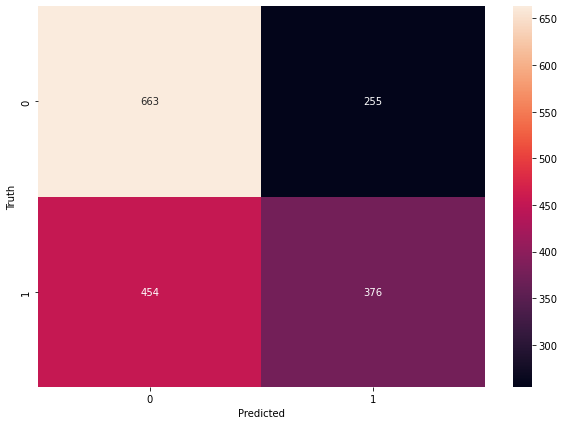

In [29]:
#Confusion Matrix
y_pred = lsvc_grid.predict(X_train)
cm = confusion_matrix(y_train, y_pred)

#Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

#Classification Report
print(classification_report(y_train, y_pred))

In [30]:
lsvc_pipe = Pipeline([('scaler', StandardScaler()),('lsvc',LinearSVC(C=10,dual=True,penalty='l2',tol=0.001))])

Extra Trees Classifier

In [31]:
from sklearn.ensemble import ExtraTreesClassifier

#Pipeline
et_pipe = Pipeline([('scaler', StandardScaler()),('et',ExtraTreesClassifier())])

#Param for ET
param_grid = {
    'et__n_estimators': [10, 50, 100, 200],
    'et__max_depth': [3, 5, 7, 9],
    'et__min_samples_split': [2, 5, 10, 15],
    'et__min_samples_leaf': [1, 2, 5, 10],
    'et__max_features': ['sqrt', 'log2', None]
}

#KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#GridSearchCV
et_grid = GridSearchCV(et_pipe, param_grid, cv=kf, verbose=1, n_jobs=-1)

#Fit
et_grid.fit(X_train,y_train)


#Best score
et_best = et_grid.best_score_

#Best parameters
et_grid.best_params_

Fitting 5 folds for each of 768 candidates, totalling 3840 fits


{'et__max_depth': 9,
 'et__max_features': None,
 'et__min_samples_leaf': 1,
 'et__min_samples_split': 2,
 'et__n_estimators': 200}

              precision    recall  f1-score   support

       False       0.84      0.78      0.81       918
        True       0.78      0.83      0.80       830

    accuracy                           0.81      1748
   macro avg       0.81      0.81      0.81      1748
weighted avg       0.81      0.81      0.81      1748



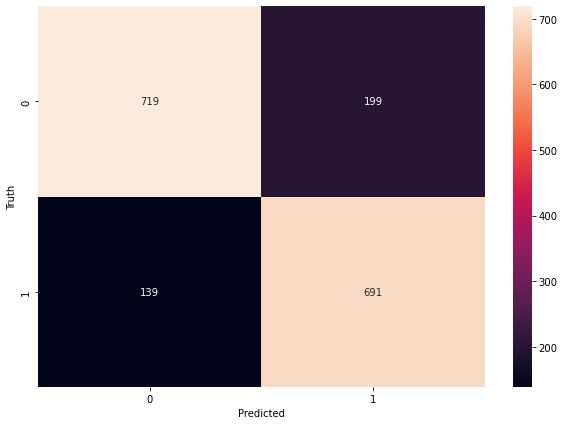

In [32]:
#Confusion Matrix
y_pred = et_grid.predict(X_train)
cm = confusion_matrix(y_train, y_pred)
 
#Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

#Classification Report
print(classification_report(y_train, y_pred))

In [33]:
et_pipe = Pipeline([('scaler', StandardScaler()),('et',ExtraTreesClassifier(n_estimators=50,max_depth=9,max_features='sqrt',min_samples_leaf=2,min_samples_split=5))])

# Results and Evaluation

The Score for Random Forest is 0.6722161277118298
The Score for XGBoost is 0.6681882930822759
The Score for KNN is 0.6247187883749488
The Score for Linear SVC is 0.5996889779559117
The Score for Extra Trees is 0.666480556692591


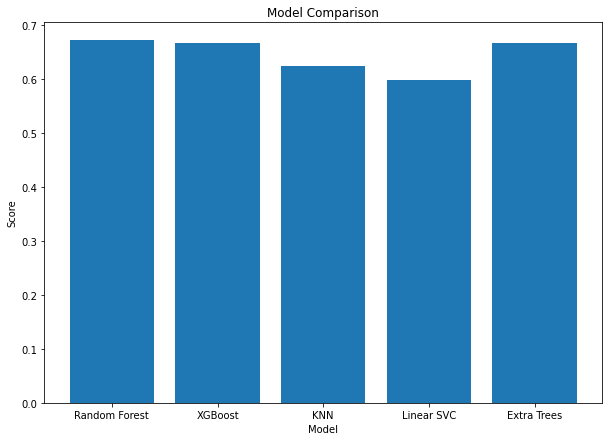

The best model is Random Forest


In [34]:
#create a dict of the best model and score
best_model = {'Random Forest': [rf_best,rf_pipe], 'XGBoost': [xgb_best,xgb_pipe], 'KNN': [knn_best,knn_pipe], 'Linear SVC': [lsvc_best,lsvc_pipe], 'Extra Trees': [et_best,et_pipe]}

#loop through the model and create a histogram
for model in best_model:
    print(f"The Score for {model} is {best_model[model][0]}")

#plot the histogram
plt.figure(figsize=(10, 7))
plt.bar(best_model.keys(), [best_model[model][0] for model in best_model])
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.show()

classifier = max(best_model, key=best_model.get)
print("The best model is", classifier)


# Conclusion

When performing classification, the extraction of features assisted in having a better understanding of the data, the use of KFold assisted in reducing variance and highest fold result is saved from the best result of the best parameters. The confusion matrix, from SVC shows that there is a balanced labelling between the two labels and this is shown, in the classification report also justifies this as the f1 score, is closely balanced, indicating a close weighing between the recall and precision, the area under curve is 68% indicating that 68% of the data is labelled as true.
For the Random forest classifier, there is a balanced recall and there is more true positive labels compared to SVC, the XGBoost also presents such case as the classification report where f1 score indicates a balanced between recall and precision this can be attributed to the balanced dataset.


# Future Works

For future work, there are a changes that could be proposed:
   1) Data  sampling to assist whenever there is an unbalanced dataset.
   2) Use of StratifiedKFold - deal with unbalanced data
   3) Use of Neural Networks - Neural Networks, assist in the advancing the application.